# Station catalog

This site provides an overview of available solar irradiance monitoring stations worldwide and metadata of the stations.
The metadata fields are further described in the [metadata](station_metadata) section.

The table is also available to download in CSV form: {download}`SolarStationsOrg-station-catalog.csv`


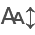

In [15]:
import pandas as pd
import numpy as np
import json
import kgcpy
from unidecode import unidecode
from itables import init_notebook_mode, show
init_notebook_mode(all_interactive=True)

# Load stations
solarstations = pd.read_csv('../solarstations.csv', dtype={'Tier': str}).fillna('')
esmap_stations = pd.read_csv('../esmap_stations.csv', dtype={'Tier': str}).fillna('')
stations = pd.concat([solarstations, esmap_stations], axis='rows', ignore_index=True)

with open('../data/country_by_continent.json') as f:
    country_by_continent = json.load(f)

stations['Continent'] = stations['Country'].map(country_by_continent)

stations['Koeppen Geiger classification'] = stations.apply(lambda x: kgcpy.lookupCZ(x['Latitude'], x['Longitude']), axis=1)
kg_climates = {'A': 'Tropical', 'B': 'Dry', 'C': 'Temperate', 'D': 'Continental', 'E': 'Polar', 'O': 'Ocean'}
stations['Koeppen Geiger climate zone'] = stations['Koeppen Geiger classification'].apply(lambda x: kg_climates[x[0]])

instrumentation = stations['Instrumentation'].str.split(';', expand=True)
is_tier_1 = (instrumentation=='G').any(axis=1) & (instrumentation=='B').any(axis=1) & (instrumentation=='D').any(axis=1)
stations['Tier'] = 2 - is_tier_1.astype(int)

annual_irradiance = pd.read_csv('../data/nasa_power_annual_irradiance_global.csv', index_col=[0, 1])
for index, row in stations.iterrows():
    lat_round = round(row['Latitude']*2-0.5, 0)/2 + 0.25
    lon_round = round(row['Longitude']*2-0.5, 0)/2 + 0.25
    try:
        stations.loc[index, ['GHI_typical_kWh_m2', 'DHI_typical_kWh_m2', 'DNI_typical_kWh_m2']] = \
            annual_irradiance.loc[(lat_round, lon_round), :]
    except KeyError as e:
        pass
    # Manual add data missing from the climatological file (data retrieved from NASA's webinterface)
    if row['Station name'] == 'Funafuti':
        stations.loc[index, ['GHI_typical_kWh_m2', 'DHI_typical_kWh_m2', 'DNI_typical_kWh_m2']] = \
            np.array([5.33*365, 2.12*365, 4.37*365]).astype(int)
    if row['Station name'] == 'South Pole':
        stations.loc[index, ['GHI_typical_kWh_m2', 'DHI_typical_kWh_m2', 'DNI_typical_kWh_m2']] = \
            np.array([3.0*365, 1.38*365, 5.13*365]).astype(int)

stations = stations[~stations['Instrumentation'].str.contains('G;Ds')]  # remove Tier 3 stations

stations = stations.sort_values('Station name', ignore_index=True)

# Write file containing all columns, linked to above
stations.to_csv('./SolarStationsOrg-station-catalog.csv', index=False)

# Format station name as hyperlinks if URL is available.
# Do this after the new CSV is written, since we don't want HTML in that.
for index, row in stations.iterrows():
    if row['URL'].startswith('http'):
        stations.loc[index, 'Station name'] = f'<a href="{row["URL"]}">{row["Station name"]}</a>'

del stations['URL']  # Remove the URL column to avoid cluttering the site

# Reorder station columns
old_column_order = list(stations.columns)
old_column_order.remove('Continent')
new_column_order = old_column_order[:4] + ['Continent'] + old_column_order[4:]
stations = stations[new_column_order]

# Show table with stations (all rows)
show(stations, scrollY="700px", scrollX=True, scrollCollapse=True, paging=False, classes="display", order=[[0, "asc"]],
     columnDefs=[{"className": "dt-left", "targets": "_all"}], maxBytes=0,
)